# Лабораторная работа №0
## ИНСТРУМЕНТАЛЬНЫЕ СРЕДСТВА АНАЛИЗА И ПРОГНОЗИРОВАНИЯ ВРЕМЕННЫХ РЯДОВ
Комлева Юлия Владимировна

Вариант: 9

Группа: РИМ-281226
### Декомпозиция ВР вида 3 кратные сезонные компоненты + шум.

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
import random
%matplotlib inline

### Кратные сезонные компоненты

In [2]:
random.seed(13)
np.random.seed(13)

t = np.linspace(0, 1, 1024)

#линейная частота сезона
f = 10 #P = 1/10

S1 = np.sin(2*np.pi*2*f*t)
S2 = np.sin(2*np.pi*4*f*t)
S3 = np.sin(2*np.pi*8*f*t)

noise = 0.2*rand.randn(len(t))

S = S1 + S2 + S3 + noise

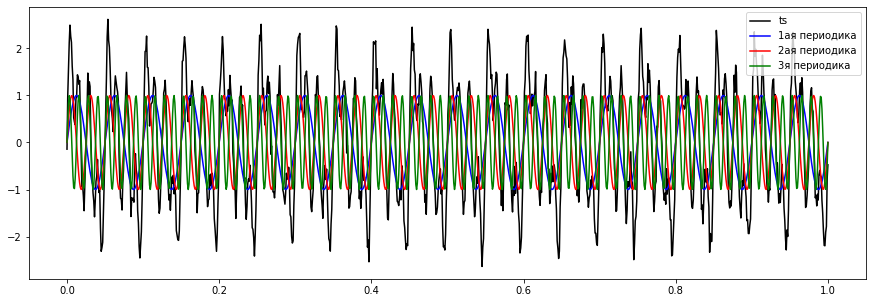

In [3]:
plt.figure(figsize = (15, 5))
plt.plot(t, S, 'k', label = 'ts')
plt.plot(t, S1, 'b', label = '1ая периодика')
plt.plot(t, S2, 'r', label = '2ая периодика')
plt.plot(t, S3, 'g', label = '3я периодика')
#plt.axvline(x=0)
#plt.axvline(x=0.05)
plt.legend()
plt.show()

### Декомпозиция ВР
### 1) Метод Сингулярного Спектрального Анализа SSA  (lab 5)
Метод сингулярного спектрального анализа SSA:

I. Этап разложения
1. Шаг вложения
2. Шаг сингулярного разложения
    
II. Этап восстановления
1. Шаг группировки
2. Шаг усреднения

#### I. Этап разложения
##### 1. Шаг вложения
$F=f(t)=\left\{ f(t_0),...,f(t_{N-1})\right\}$ - исследуемый временной ряд с числом отсчетов $N$, $t_i=i\Delta t,$, где $\Delta t$ - период выборки.

Процедура вложения переводит исходный временной ряд в последовательность многомерных векторов. Процедура вложения образует $K=N-L+1$ векторов вложения, имеющих размерность $L$.
$$X_i=(f_{i-1},...,f_{i+L-2})^T,~1 \leq i\leq K$$
$X$ - траекторная матрица ряда $F$ и состоит из векторов вложения  в качестве столбцов $X=[X_1:...:X_K]$
$$X=\left( x_{ij}\right) ^{L,K}_{i,j=1}=\left( \begin{matrix}f_0&&f_1&&f_2&&\cdots &&f_{K-1} \\ f_1&&f_2&&f_3&&\cdots &&f_K \\ f_2&&f_3&&f_4&&\cdots &&f_{K+1} \\ \vdots &&\vdots &&\vdots && \ddots &&\vdots \\ f_{L-1}&&f_L&&f_{L+1}&&\cdots &&f_{N-1}\end{matrix}\right)$$
Очевидно, что $x_{ij}=f_{i+j-2}$ и поэтому матрица $X$ имеет одинаковые элементы на «диагоналях» $i+j=const$. Таким образом, траекторная матрица является ганкелевой. Существует взаимно-однозначное соответствие между ганкелевыми матрицами размерности $L\times K$ и рядами длины $N=L+K-1$
##### 2. Шаг сингулярного разложения
Singular Value Decomposition = SVD траекторной матрицы ряда. 

Пусть $S=XX^T$. $\lambda _1,...,\lambda _L$ - собственные числа матрицы $S$, взятые в неубывающем порядке $(\lambda  _1 \geq \lambda  _2 \geq ... \geq \lambda _L \geq 0)$ и $U_1,...,U_L$ – ортонормированную систему собственных векторов матрицы $S$, соответствующих собственным числам.

Пусть $d=\max \{ i:\lambda _i > 0\}$. Обозначим $V_i=X^TU_i / \sqrt{\lambda _1}$, $~i=1,...,d,$. Тогда сингулярное разложение матрицы $X$: $X=X_1+...+X_d$, где $X_i=\sqrt{\lambda _i}U_iV^T_i$. 

Каждая из этих матриц $X_i$ имеет ранг 1. Поэтому их можно назвать элементарными матрицами. 

Набор $\left( \sqrt{\lambda _i},U_i,V_i\right)$ называют $i$-й __собственной тройкой__ сингулярного разложения.

In [4]:
def SSA_modes(F, L):
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K))
    #шаг вложения
    for i in range(0, L): #rows
        for j in range(0, K):
            X[i,j] = F[i+j]
    #X = np.column_stack([F[i:i+L] for i in range(0,K)])
    #шаг сингулярного разложени]
    S = np.dot(X, X.T)
    U, A, _ = np.linalg.svd(S)
    # U - матрица собственных векторов
    # A - массив собственных чисел (в неубывающем порядке)
    V = np.dot(X.T, U) #матрица траекторных векторов
    return A, U, V

#### II. Этап восстановления
##### 1. Шаг группировки
На основе разложения $X=X_1+...+X_d$, где $X_i=\sqrt{\lambda _i}U_iV^T_i$ процедура группировки, по сути, делит все множество индексов $\{1,...,d\}$ на $m$ непересекающихся подмножеств $I_1,...,I_m$.

Пусть $I=\{i_1,...i_p\}$. Тогда результирующая матрица $X_I$  соответствующая группе $I$ определяется как $X_I=X_{i_1}+...+X_{i_p}$. Такие матрицы вычисляются для $I=I_1,...,I_m$, тем самым разложение  может быть записано в сгруппированном виде: $X=X_{I_1}+...+X_{I_m}$

Процедура выбора множеств $I=I_1,...,I_m$ и называется группировкой собственных троек. 
##### 2. Шаг диагонального усреднения
Каждая матрица сгруппированного разложения переводится в новый ряд длины $N$.

Пусть $Y$ – некоторая $L\times K$ матрица с элементами $y_{ij}$, где $1 \leq i \leq  L$, $1\leq j \leq K$.  Положим $L^*=\min(L,K)$, $K^*=\max(L,K)$  и $N=L+K-1$. Пусть $y^*_{ij}=y_{ij},$ если $L\leq K$ и $y^*_{ij}=y_{ij}$ – иначе. 

__Диагональное усреднение__ переводит матрицу  во временной ряд  по формуле:

$$g_k=\left\{ \begin{matrix} \frac {1}{k+1}\sum \limits^{k+1}_{m=1}y^*_{m,k-m+2} && 0\leq k < L^*-1, \\ \frac {1}{L^*}\sum \limits^{L^*}_{m=1}y^*_{m,k-m+2}&&L^*-1\leq k < K^*, \\ \frac {1}{N-k}\sum \limits^{N-K^*+1}_{m=k-K+2}y^*_{m,k-m+2}&&K^*\leq k<N.\end{matrix} \right. $$


In [5]:
def SSA_group(A, U, V, N, I):
    
    L = len(A)
    K = N - L + 1

    #шаг группировки
    V = V.transpose()
    Z = np.dot(U[:, I], V[I, :])

    #этап диагонального усреднения
    G = np.zeros(N)
    L_ = min(L, K)
    K_ = max(L, K)    
    
    for k in range(0, L_):
        for m in range(0, k + 1):
            G[k] += Z[m][k-m]
        G[k] *= 1/(k+1)
    for k in range(L_, K_):
        for m in range(0, L_):    
            G[k] += Z[m][k-m]   
        G[k] *= 1/L_
    for k in range(K_, N):
        for m in range(k-K_+1, N-K_+1):
            G[k] += Z[m][k-m]
        G[k] *= 1/(N-k)
    return G

In [6]:
N = 1024
L = 88
K = N-L+1
w_min_diff = 1/min(L,K)
print(w_min_diff)

0.011363636363636364


#### Выбор ширины окна

In [7]:
arr1 = []
arr2 = []
arr3 = []
s1 = S1 #S2 S3
s2 = S2
s3 = S3
for i in range(2, 100):
    A, U, V = SSA_modes(S, i)
    ssaF = SSA_group(A, U, V, len(S), [0])
    arr1.append(sum(abs(s1 - ssaF)))
    arr2.append(sum(abs(s2 - ssaF)))
    arr3.append(sum(abs(s3 - ssaF)))
    #print(i, sum(abs(trend - ssaF)))

In [8]:
L1 = np.argmin(arr1)+2
L2 = np.argmin(arr2)+2
L3 = np.argmin(arr3)+2
L1, L2, L3

(39, 18, 52)

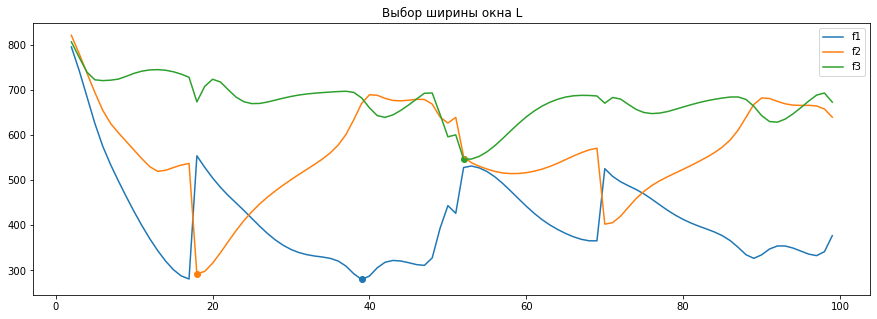

In [9]:
plt.figure(figsize = (15, 5))
plt.title("Выбор ширины окна L")
plt.plot(range(2, 100), arr1, label='f1')
plt.plot(range(2, 100), arr2, label='f2')
plt.plot(range(2, 100), arr3, label='f3')
plt.scatter(L1, arr1[L1-2]) # np.argmin(arr) + 2
plt.scatter(L2, arr2[L2-2]) # np.argmin(arr) + 2
plt.scatter(L3, arr3[L3-2]) # np.argmin(arr) + 2
# 1 17 15
# 2 34 32
# 3 27 25
plt.legend()
plt.show()

In [10]:
L = 39#41

In [11]:
A, U, V = SSA_modes(S, L)

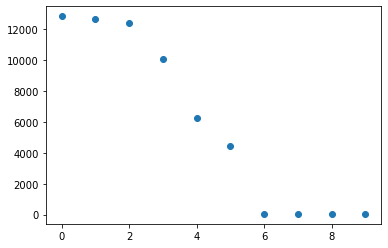

In [12]:
plt.scatter(range(10),A[:10])
plt.show()

In [13]:
A, U, V = SSA_modes(S, L)
ssaF0 = SSA_group(A, U, V, len(S), [0])
ssaF1 = SSA_group(A, U, V, len(S), [1])
ssaF2 = SSA_group(A, U, V, len(S), [2])
ssaF3 = SSA_group(A, U, V, len(S), [3])
ssaF4 = SSA_group(A, U, V, len(S), [4])
ssaF5 = SSA_group(A, U, V, len(S), [5])

ssaF01 = SSA_group(A, U, V, len(S), [0, 1])
ssaF02 = SSA_group(A, U, V, len(S), [0, 2])
ssaF03 = SSA_group(A, U, V, len(S), [0, 3])
ssaF04 = SSA_group(A, U, V, len(S), [0, 4])
ssaF05 = SSA_group(A, U, V, len(S), [0, 5])

ssaF12 = SSA_group(A, U, V, len(S), [1, 2])
ssaF13 = SSA_group(A, U, V, len(S), [1, 3])
ssaF14 = SSA_group(A, U, V, len(S), [1, 4])
ssaF15 = SSA_group(A, U, V, len(S), [1, 5])

ssaF23 = SSA_group(A, U, V, len(S), [2, 3])
ssaF24 = SSA_group(A, U, V, len(S), [2, 4])
ssaF25 = SSA_group(A, U, V, len(S), [2, 5])

ssaF34 = SSA_group(A, U, V, len(S), [3, 4])
ssaF35 = SSA_group(A, U, V, len(S), [3, 5])

ssaF45 = SSA_group(A, U, V, len(S), [4, 5])

ssaF234 = SSA_group(A, U, V, len(S), [2, 3, 4])

In [31]:
ssaF6 = SSA_group(A, U, V, len(S), [6])

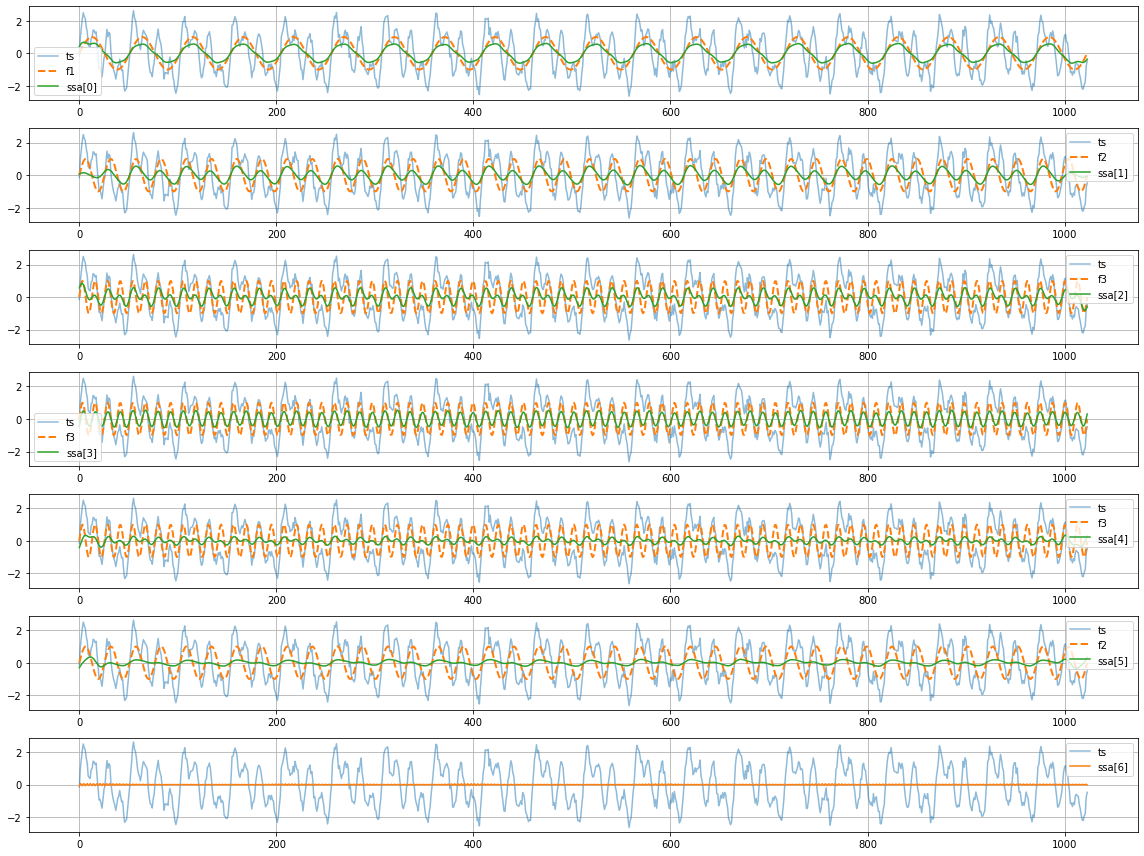

In [32]:
fig, ax = plt.subplots(7, 1, figsize=(16, 12), sharey = True)

ax[0].plot(S, label = 'ts', alpha=0.5)
ax[0].plot(range(1024), S1, ls = '--', lw = 2, label = 'f1')
ax[0].plot(ssaF0, label = 'ssa[0]')

ax[1].plot(S, label = 'ts', alpha=0.5)
ax[1].plot(range(1024), S2, ls = '--', lw = 2, label = 'f2')
ax[1].plot(ssaF1, label = 'ssa[1]')

ax[2].plot(S, label = 'ts', alpha=0.5)
ax[2].plot(range(1024), S3, ls = '--', lw = 2, label = 'f3')
ax[2].plot(ssaF2, label = 'ssa[2]')

ax[3].plot(S, label = 'ts', alpha=0.5)
ax[3].plot(range(1024), S3, ls = '--', lw = 2, label = 'f3')
ax[3].plot(ssaF3, label = 'ssa[3]')

ax[4].plot(S, label = 'ts', alpha=0.5)
ax[4].plot(range(1024), S3, ls = '--', lw = 2, label = 'f3')
ax[4].plot(ssaF4, label = 'ssa[4]')

ax[5].plot(S, label = 'ts', alpha=0.5)
ax[5].plot(range(1024), S2, ls = '--', lw = 2, label = 'f2')
ax[5].plot(ssaF5, label = 'ssa[5]')

ax[6].plot(S, label = 'ts', alpha=0.5)
#ax[6].plot(range(1024), S2, ls = '--', lw = 2, label = 'f2')
ax[6].plot(ssaF6, label = 'ssa[6]')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[4].grid()
ax[5].grid()
ax[6].grid()

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()

plt.tight_layout()
plt.show()

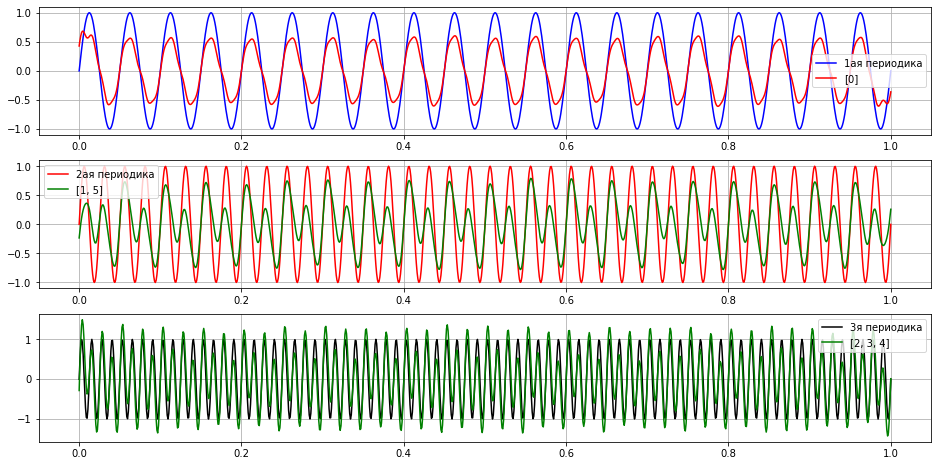

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(16, 8))
ax[0].plot(t, S1, 'b')
ax[0].plot(t, ssaF0, 'r')

ax[1].plot(t, S2, 'r')
ax[1].plot(t, ssaF15, 'g')

ax[2].plot(t, S3, 'k')
ax[2].plot(t, ssaF234, 'g') 

ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].legend(["1ая периодика", "[0]"])
ax[1].legend(["2ая периодика", "[1, 5]"])
ax[2].legend(["3я периодика", "[2, 3, 4]"])
plt.show()

При наличии в задании слова «шум», после декомпозиции полученный
остаточный ряд (или выделенный шум) необходимо оценить на случайность
любым из статистических критериев.
# Шум

In [43]:
noiseSSA = S - ssaF0  - ssaF234 - ssaF15

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [23]:
from statsmodels import api as sm

In [ ]:
import scipy
scipy.__version__

In [ ]:
import statsmodels
statsmodels.__version__

In [40]:
sm.tsa.kpss(noiseSSA, lags = 'auto')

C:\Users\usr\Anaconda3\envs\Py36\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.10077003438222897,
 0.1,
 138,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [52]:
#sm.tsa.adfuller(noiseSSA)
result = sm.tsa.adfuller(noiseSSA, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.749186160674201
p-value: 0.06590673154555053
Critial Values:
   1%, -3.4368995989062348
Critial Values:
   5%, -2.8644316780522177
Critial Values:
   10%, -2.568309666527279


In [55]:
# KPSS Test
result = sm.tsa.kpss(noiseSSA, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.154957
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\usr\Anaconda3\envs\Py36\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\usr\Anaconda3\envs\Py36\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [42]:
sm.tsa.bds(noiseSSA)

(array(2.17902691), array(0.02932967))

# Проверка случайности ряда остатков
## Критерий поворотных точек (turning point test)
При наличии в задании слова «шум», после декомпозиции полученный остаточный ряд (или выделенный шум) необходимо оценить на случайность любым из статистических критериев.


In [225]:
def noise_test(noise):
    plt.figure(figsize = (15, 5))
    plt.title("noise")
    plt.plot(t, noise, label='noise')

    plt.legend()
    plt.show()
    #plt.figure(figsize = (15, 5))
    #pd.plotting.autocorrelation_plot(noiseSSA);
    #plt.show()
    #plt.figure(figsize = (15, 5))
    plot_acf(noise, lags = 20);
    plt.show()
    #plt.figure(figsize = (15, 5))
    plot_pacf(noise, lags = 20);
    plt.show()
    
    

    print(pd.Series(noise).describe())

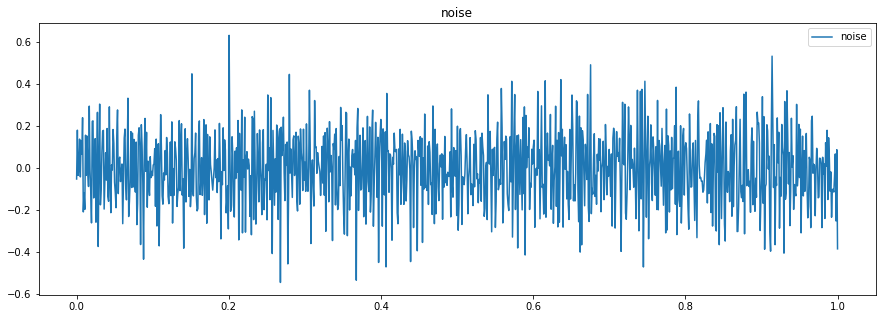

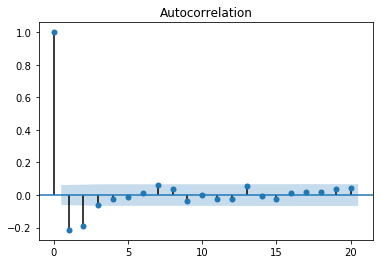

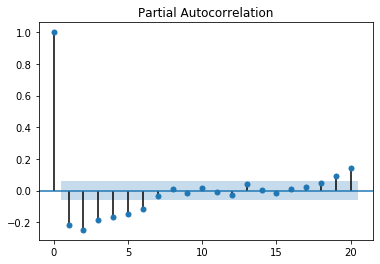

count    1024.000000
mean       -0.003348
std         0.177058
min        -0.545042
25%        -0.125591
50%         0.000293
75%         0.129818
max         0.632209
dtype: float64


In [226]:
noise_test(noiseSSA)

In [61]:
import math
def turningPoint(a, b, c):
    result = 0       # не поворотная точка
    if ((a < b) and (b > c)):
        result = 1    # пик
    elif ((a > b) and (b < c)):
        result = -1   # впадина
    return result
def turningPointsCounter(n, a):
    k = 0  # счётчик поворотных точек
    for i in range(1, n-1): # для всех элементов, кроме 0-го и последнего
        k += abs(turningPoint(a[i-1], a[i], a[i+1]))

    k0 = 2.0 * (n - 2) / 3.0  # теоретическое среднее значение числа поворотных точек
    d = (16.0 * n - 29.0) / 90.0  # дисперсия 
    dk95 = 1.96 * math.sqrt(d)    # пороговое отклонение для вероятности 0.95
    return [k, k0, d, dk95]
def printResult(k, k0, dk95):
    print("Число поворотных точек = %d" % k)
    print("отличается от теоретического значения %1.2f" % k0)
    dk = k - k0
    print("на %1.2f" % dk)
    print("Пороговая разница = %1.2f" % dk95) 
    if (abs(dk) < dk95):
        print("Не можем отвергнуть гипотезу о случайности данной последовательности") 
    else:
        print("Последовательность не является случайной")
k, k0, d, dk95 = turningPointsCounter(1024, noiseSSA)
printResult(k, k0, dk95)

Число поворотных точек = 703
отличается от теоретического значения 681.33
на 21.67
Пороговая разница = 26.42
Не можем отвергнуть гипотезу о случайности данной последовательности


In [80]:
fs = 1/(t[1] - t[0]) # fs = 1/dt = N/T
fs

1023.0

In [198]:
def plot_spectrograms(s1, s2, s3, S, noise):
    fs = 1/(t[1] - t[0]) # fs = 1/dt = N/T
    f1, ts1, Sxx1 = signal.spectrogram(s1, fs) # возвращаем частоту от времени
    f2, ts2, Sxx2 = signal.spectrogram(s2, fs) # возвращаем частоту от времени
    f3, ts3, Sxx3 = signal.spectrogram(s3, fs) # возвращаем частоту от времени
    fS, tsS, SxxS = signal.spectrogram(S, fs) # возвращаем частоту от времени
    fnoise, tsnoise, Sxxnoise = signal.spectrogram(noise, fs) # возвращаем частоту от времени
    
    fig, ax = plt.subplots(5, 1, figsize=(16, 16), sharex=True)
    ax[0].pcolormesh(ts1, f1, Sxx1)
    ax[0].set_title("f1 = 20")
    
    ax[1].pcolormesh(ts2, f2, Sxx2)
    ax[1].set_title("f2 = 40")
    
    ax[2].pcolormesh(ts3, f3, Sxx3)
    ax[2].set_title("f3 = 80")
    
    ax[3].pcolormesh(tsS, fS, SxxS)
    ax[3].set_title("S = s1 + s2 + s3 + noise")
    
    ax[4].pcolormesh(tsnoise, fnoise, Sxxnoise)
    ax[4].set_title("noise")
    ax[4].set_xlabel("Time [sec]")
  
    for a in ax.flat:
        a.set(ylabel='Frequency [Hz]', ylim=(0,100))
    plt.show()

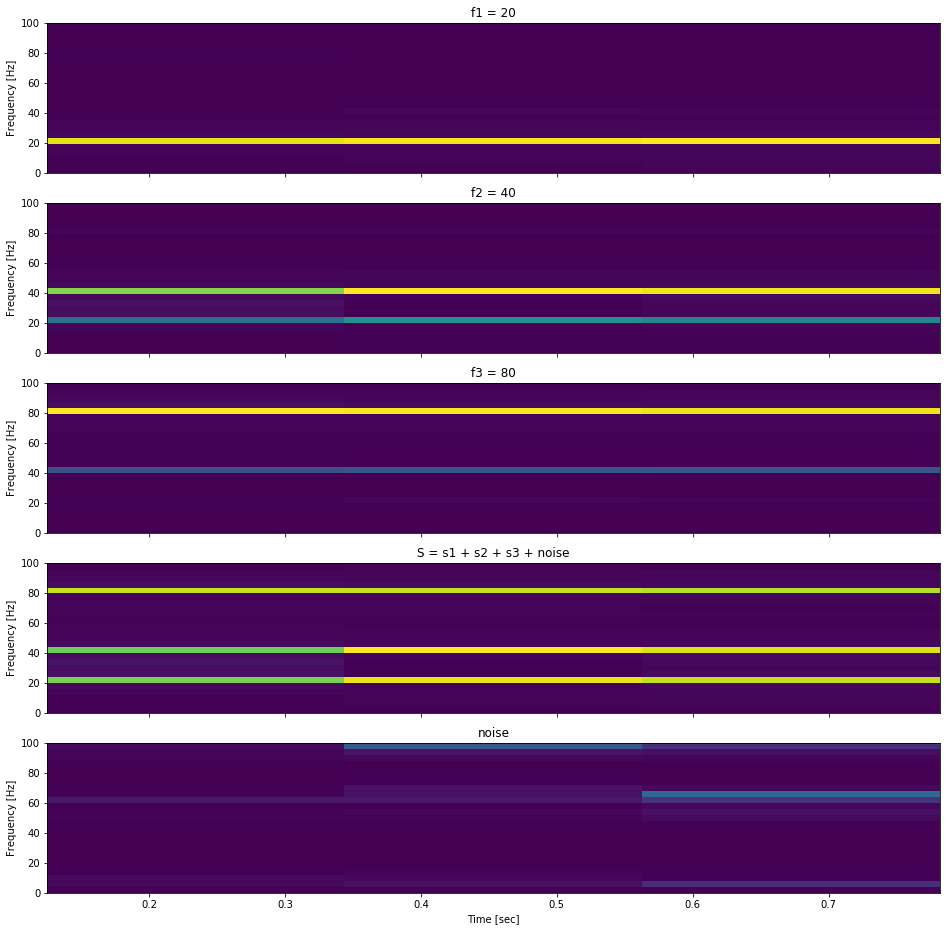

In [199]:
plot_spectrograms(ssaF0, ssaF15, ssaF234, S, noiseSSA)

In [151]:
def hilbert_instantaneous_frequency(s):
    # аналитический сигнал
    analytic_signal = signal.hilbert(s)
    # мгновенная фаза в развернутом непрерывном виде
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # мгновенная частота как производная от фазы, приведенная в Гц
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
    return instantaneous_frequency

def plot_hilbert(s1, s2, s3, noise):
    instantaneous_frequency_s1 = hilbert_instantaneous_frequency(s1)
    instantaneous_frequency_s2 = hilbert_instantaneous_frequency(s2)
    instantaneous_frequency_s3 = hilbert_instantaneous_frequency(s3)
    instantaneous_frequency_noise = hilbert_instantaneous_frequency(noise)
    
    t_cut = t[1:]
    fig, ax = plt.subplots(5, 1, figsize=(16, 10))
    ax[0].plot(t_cut, instantaneous_frequency_s1, 'b')
    ax[0].plot(t_cut, [20]*1023, 'g')
    ax[1].plot(t_cut, instantaneous_frequency_s2, 'r')
    ax[1].plot(t_cut, [40]*1023, 'g')
    ax[2].plot(t_cut, instantaneous_frequency_s3, 'k')
    ax[2].plot(t_cut, [80]*1023, 'g')
    
    ax[3].plot(t_cut, instantaneous_frequency_s1, 'b')
    ax[3].plot(t_cut, [20]*1023, 'g')
    ax[3].plot(t_cut, instantaneous_frequency_s2, 'r')
    ax[3].plot(t_cut, [40]*1023, 'g')
    ax[3].plot(t_cut, instantaneous_frequency_s3, 'k')
    ax[3].plot(t_cut, [80]*1023, 'g')
    
    ax[4].plot(t_cut, instantaneous_frequency_noise, 'k')

    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()
    ax[4].grid()

    ax[0].legend(["f1 = 10 * 2 = 20", "base 20"])
    ax[1].legend(["f2 = 10 * 4 = 40", "base 40"])
    ax[2].legend(["f3 = 10 * 8 = 80", "base 80"])
    ax[3].legend(["f1","base f1", "f2", "base f2", "f3", "base f3"])
    ax[4].legend(["noise"])
    plt.show()

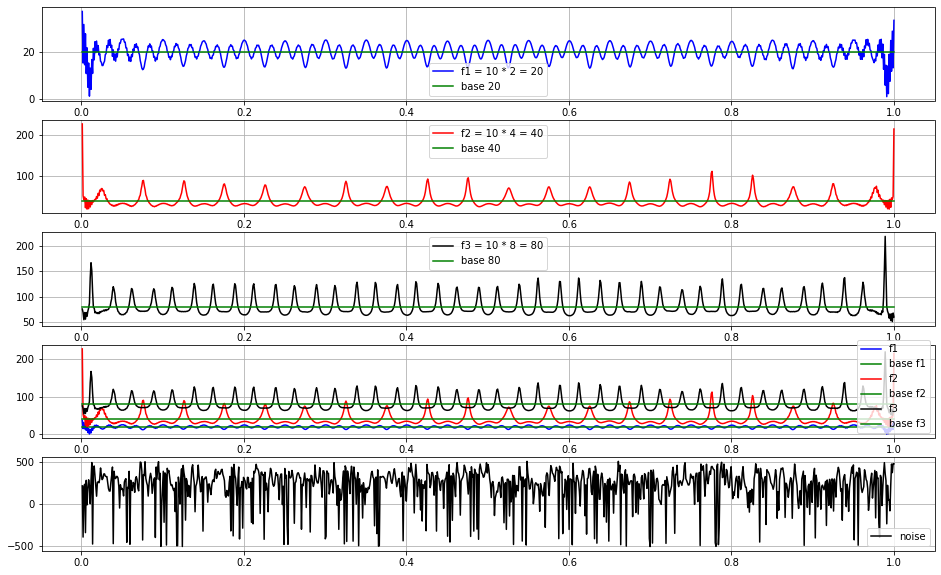

In [153]:
plot_hilbert(ssaF0, ssaF15, ssaF234, noiseSSA)

In [ ]:
plot

### 2) Метод Вейвлетной Декомпозиции (lab 6)

In [62]:
import pywt

In [63]:
wp = pywt.WaveletPacket(data=S, wavelet='dmey', mode='periodization')
print([node.path for node in wp.get_level(4, 'freq')]) 

['aaaa', 'aaad', 'aadd', 'aada', 'adda', 'addd', 'adad', 'adaa', 'ddaa', 'ddad', 'dddd', 'ddda', 'dada', 'dadd', 'daad', 'daaa']


In [64]:
wp = pywt.WaveletPacket(data=S, wavelet='dmey', mode='periodization')
new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')

new_wp['aaaa'] = wp['aaaa'].data # выбираем первую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF1 = new_wp.data # восстанавливаем под нее ряд 1

new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aaad'] = wp['aaad'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF2 = new_wp.data # восстанавливаем под нее ряд 2

new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aadd'] = wp['aadd'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF3 = new_wp.data # восстанавливаем под нее ряд 2

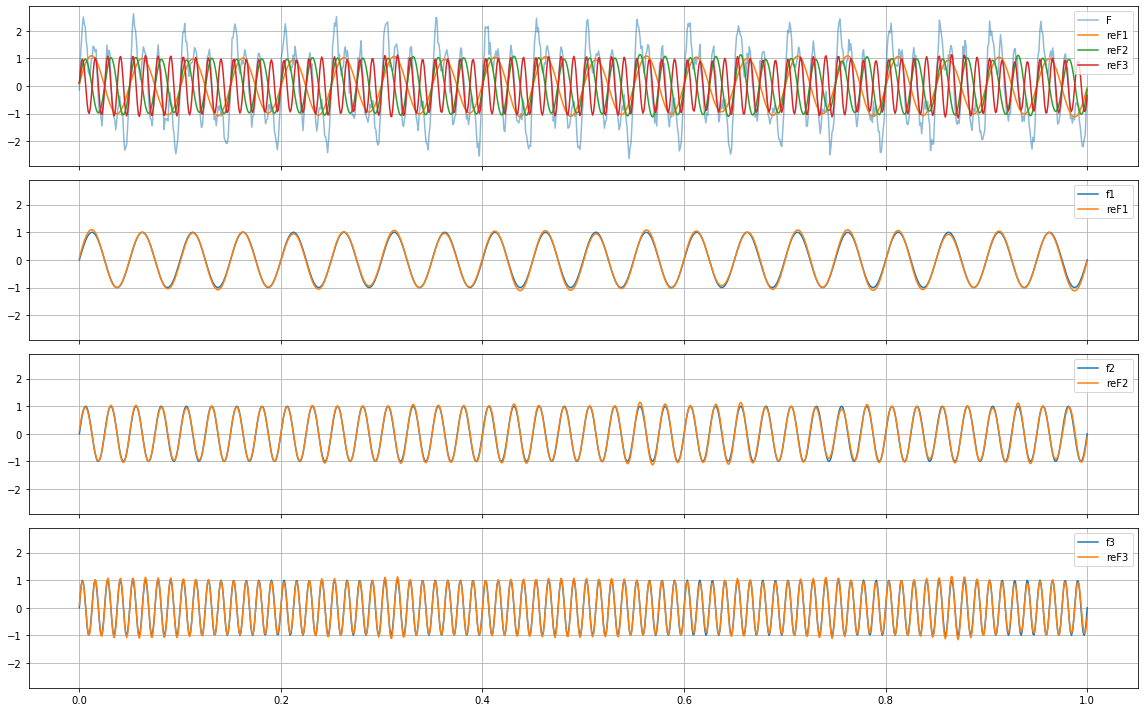

In [65]:
fig, ax = plt.subplots(4, 1, figsize=(16, 10), sharex = True, sharey=True)
ax[0].plot(t, S, alpha = 0.5, label = 'F')
ax[0].plot(t, reF1, label = 'reF1') # нормируем на уровень 5
ax[0].plot(t, reF2, label = 'reF2') # нормируем на уровень 4
ax[0].plot(t, reF3, label = 'reF3') # нормируем на уровень 4

ax[1].plot(t, S1, label = 'f1')
ax[1].plot(t, reF1, label = 'reF1')

ax[2].plot(t, S2, label = 'f2')
ax[2].plot(t, reF2, label = 'reF2')

ax[3].plot(t, S3, label = 'f3')
ax[3].plot(t, reF3, label = 'reF3')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.tight_layout()
plt.show()

In [66]:
noiseWT = S - reF1 - reF2 - reF3

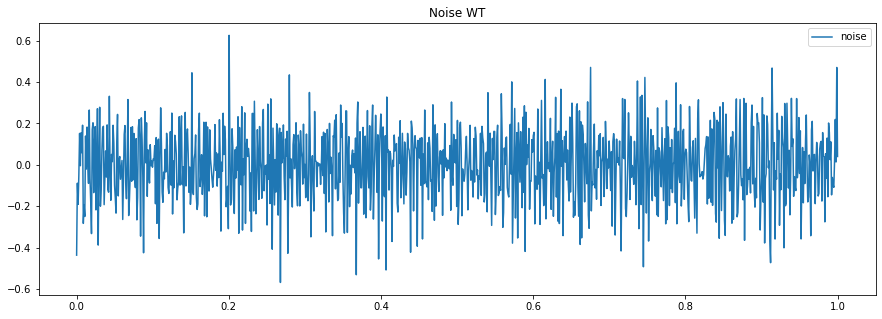

In [68]:
plt.figure(figsize = (15, 5))
plt.title("Noise WT")
plt.plot(t, noiseWT, label='noise')

plt.legend()
plt.show()

In [69]:
k, k0, d, dk95 = turningPointsCounter(1024, noiseWT)
printResult(k, k0, dk95)

Число поворотных точек = 701
отличается от теоретического значения 681.33
на 19.67
Пороговая разница = 26.42
Не можем отвергнуть гипотезу о случайности данной последовательности


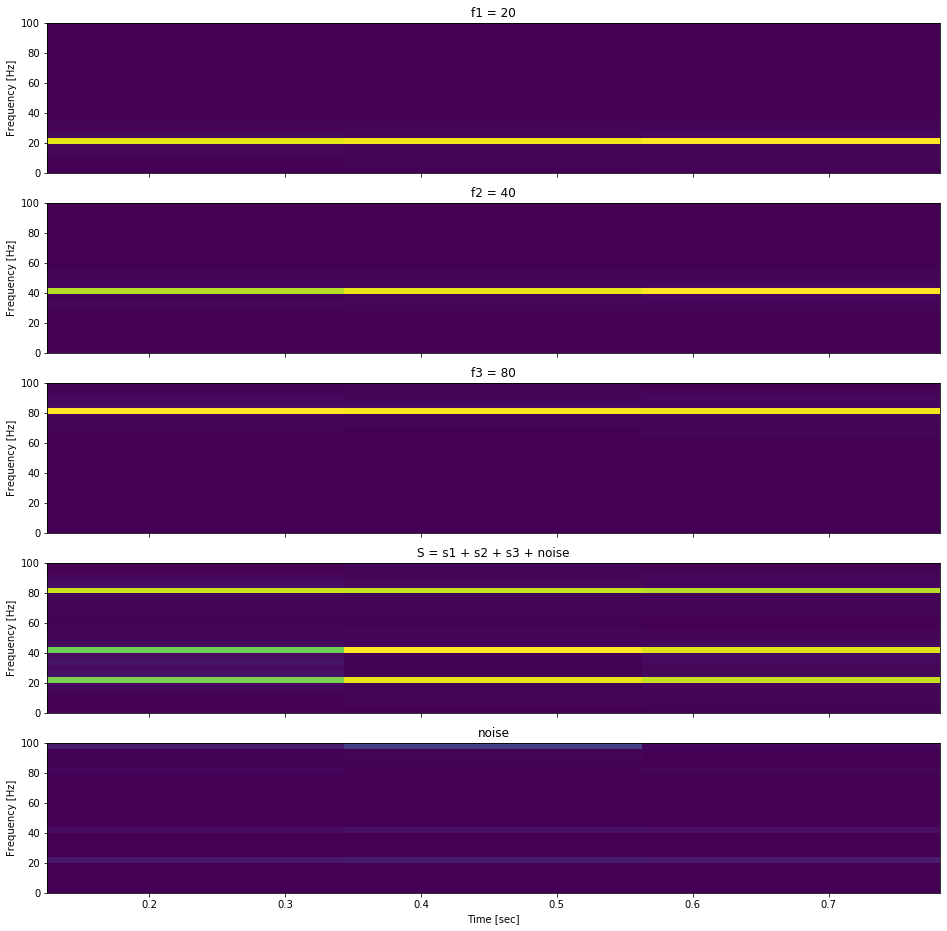

In [200]:
plot_spectrograms(reF1, reF2, reF3, S, noiseWT)

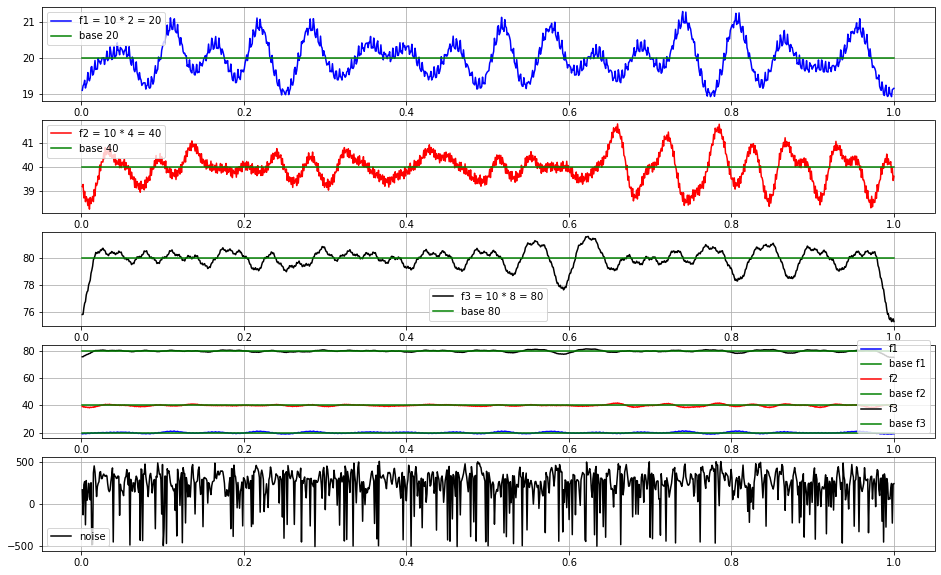

In [154]:
plot_hilbert(reF1, reF2, reF3, noiseWT)

При наличии в задании слова «шум», после декомпозиции полученный
остаточный ряд (или выделенный шум) необходимо оценить на случайность
любым из статистических критериев.
# Шум

### 3) Метод Эмпирической Модовой Декомпозиции (7)

In [70]:
import scipy as sp
from scipy import signal

In [ ]:
def inst_freq(tx, w):
    n = tx.shape[0]
    fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T
    # аналитический сигнал
    analytic_signal = signal.hilbert(w) 
    
    # мгновенная фаза в развернутом непрерывном виде
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # мгновенная частота как производная от фазы, приведенная в Гц
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
    
    # из-за численного расчета производной массив мгновенной частоты
    # будет меньше массива времени на одну точку:
    tt = np.array(tx[1:])
    return tt, instantaneous_frequency

In [ ]:
from scipy.optimize import curve_fit
def trend(t, Y, tr = 'smooth', cut = 0, window_len = 25):
    if cut > 0:
            Y = Y[cut: -cut]
            t = t[cut: -cut]
            
    if tr == 'linear':
        B_lin_curve_fit, pcov = curve_fit(f, t, Y) # проводим подгонку МНК
        print("curve fit params ", B_lin_curve_fit)
        return t, np.array(func(t, B_lin_curve_fit))
    
    elif tr == 'quadratic':
        B_quad_curve_fit, pcov = curve_fit(f2, t, Y) # проводим подгонку МНК
        print("curve fit params ", B_quad_curve_fit)
        return t, np.array(func2(t, B_quad_curve_fit))
    
    elif tr == 'hyperbolic':
        B_cubic_curve_fit, pcov = curve_fit(f3, t, Y) # проводим подгонку МНК
        print("curve fit params ", B_cubic_curve_fit)
        return t, np.array(func3(t, B_cubic_curve_fit))
    
    elif tr == 'logarithmic':
        B_log_curve_fit, pcov = curve_fit(flog, t, Y)
        print("curve fit params ", B_log_curve_fit)
        return t, np.array(funclog(t, B_log_curve_fit))
    
    elif tr == 'exponential':
        B_exp_curve_fit, pcov = curve_fit(fexp, t, Y)
        print("curve fit params ", B_exp_curve_fit)
        return t, np.array(funcexp(t, B_exp_curve_fit))
    else:
        #smooth

        half_window=window_len//2
        Y=np.concatenate([[Y[0]]*half_window, Y, [Y[-1]]*half_window])
        smoothed=[]
    
        for i in range(half_window,len(Y)-half_window):
            smoothed.append(Y[i-half_window:i+1+half_window].sum()/window_len)
        return t, np.array(smoothed)
    

In [71]:
def emd(x, n_components = 3):
    
    r = x
    rr = r
    t = np.arange(len(r))
    components = np.zeros(n_components + 1, dtype=object)
    for i in range(n_components):
        r_tmp = r
        for j in range(10):
            up_dots = sp.signal.argrelmax(r_tmp)[0]
            low_dots = sp.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = sp.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = sp.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            mean_t = _emd_complim(mean_t, up_dots, low_dots)
            
            #samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            #samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            #mean_t[:samp_start] = mean_t[samp_start]
            #mean_t[samp_end:] = mean_t[samp_end]
            


            r_tmp = r_tmp - mean_t
                
        
        components[i] = r_tmp
        r = r - components[i] 
    
    components[n_components] = r
    return components

def _emd_complim(mean_t, up_dots, low_dots):
    samp_start = np.max((np.min(up_dots),np.min(low_dots)))
    samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [74]:
def plot_emd(x, tx, tr, n_components, cut, window_len):
    components = emd(S, n_components)
    plt.figure(figsize=(16,8))
    for i in range(len(components)):
        
        plt.subplot(len(components),2,i*2+1)
        plt.plot(tx, x,color='0.6', label = 'F')
        plt.plot(tx, components[i],'k', label = 'component')
        plt.ylabel('component '+np.str(i+1))
        
        #plt.subplot(len(components),2,i*2+2)
        #tt, instantaneous_frequency = inst_freq(tx, components[i])
        #plt.plot(tx[1:], instantaneous_frequency, label = 'instantaneous_frequency', alpha = 0.5)
        
        #tt, y = trend(tt, instantaneous_frequency, tr, cut, window_len)
        #print("mean of trend %1.2f"%np.mean(y))
        #tt = tt[50:-50]

        #plt.plot(tt, y, label = 'trend')
    plt.tight_layout()
    plt.legend()
    return components

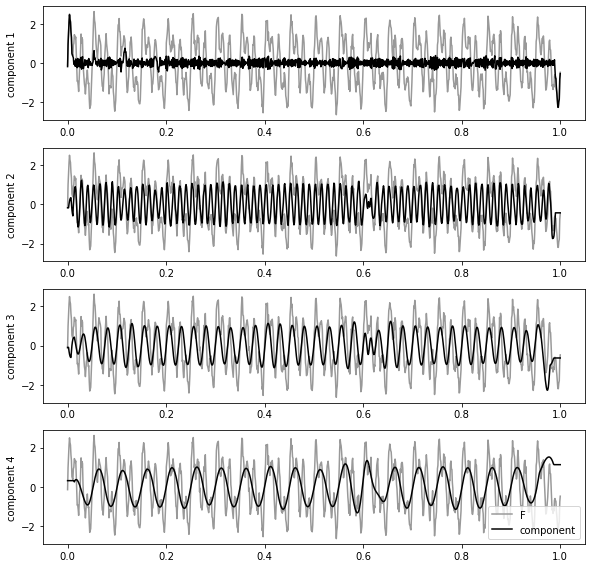

In [75]:
components = plot_emd(S, t, 'smooth', 3, 50, 51)

In [76]:
noiseEMD = S - components[1] - components[2] - components[3]

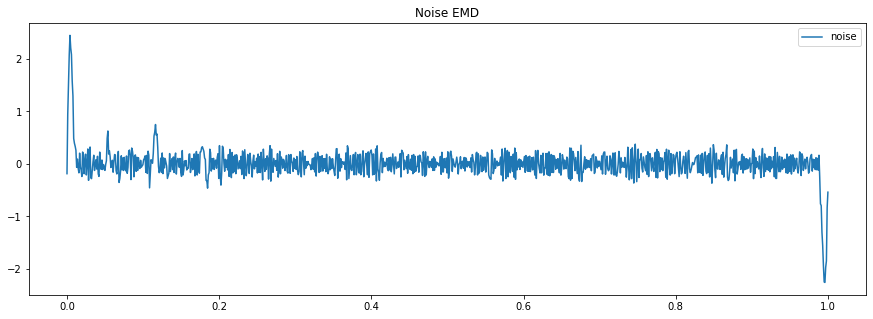

In [78]:
plt.figure(figsize = (15, 5))
plt.title("Noise EMD")
plt.plot(t, noiseEMD, label='noise')

plt.legend()
plt.show()

In [79]:
k, k0, d, dk95 = turningPointsCounter(1024, noiseEMD)
printResult(k, k0, dk95)

Число поворотных точек = 674
отличается от теоретического значения 681.33
на -7.33
Пороговая разница = 26.42
Не можем отвергнуть гипотезу о случайности данной последовательности


In [157]:
emd1, emd2, emd3 = components[3], components[2], components[1]

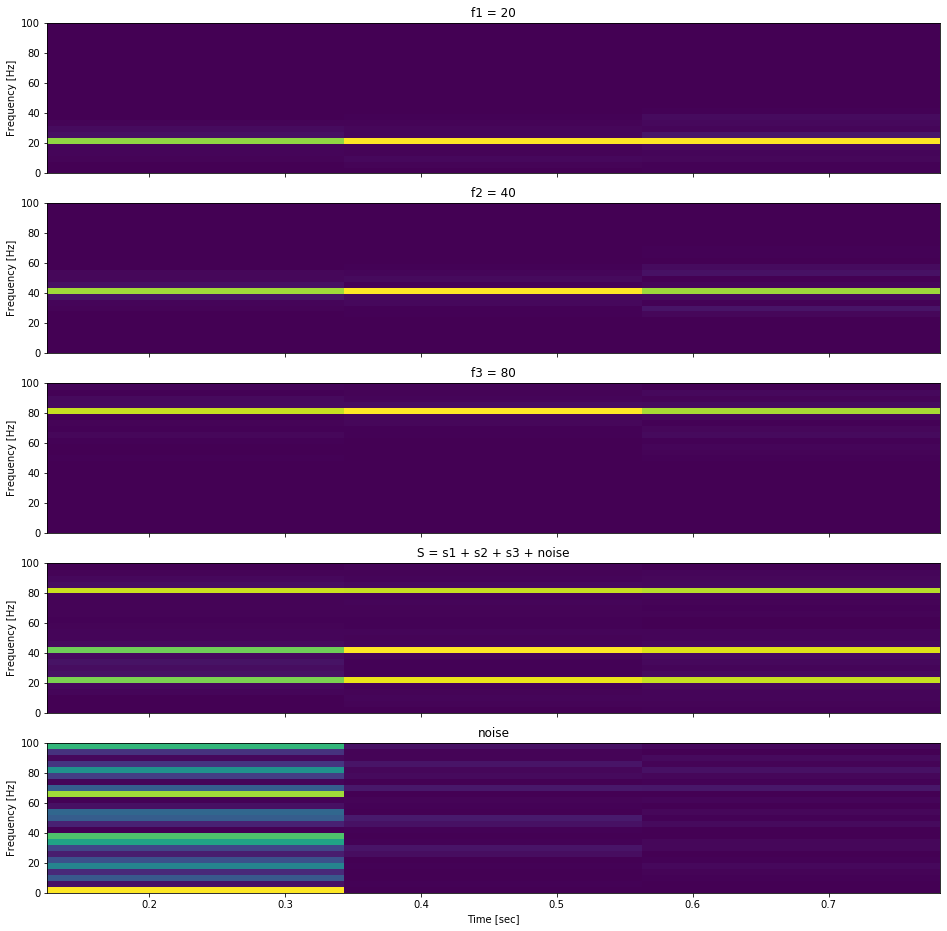

In [201]:
plot_spectrograms(emd1, emd2, emd3, S, noiseEMD)

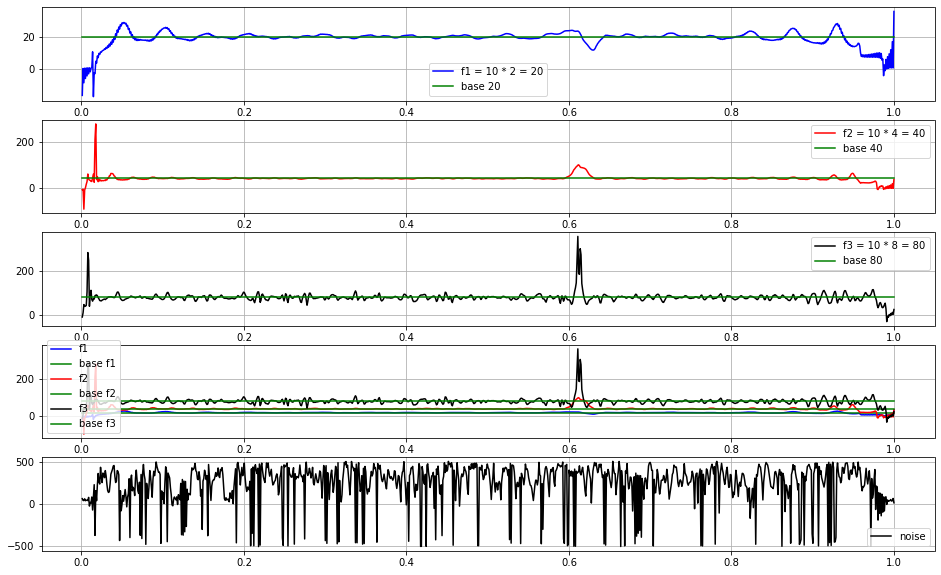

In [158]:
plot_hilbert(emd1, emd2, emd3, noiseEMD)